# Text Classification with AG's News Topics - Python API

*We recommend using a GPU runtime for this example. In the Colab menu bar, choose **Runtime** > **Change Runtime Type** and choose **GPU** under Hardware Accelerator.*

In this notebook, we will show how to use the Ludwig Python API to:


1.   [Download a Dataset](#scrollTo=Download_Dataset)
2.   [Train a Ludwig Model](#scrollTo=Train)
3.   [Evaluate the trained model](#scrollTo=Evaluate)
4.   [Visualize training and test metrics](#scrollTo=Visualize_Metrics)
5.   [Make predictions on New Data](#scrollTo=Make_Predictions_on_New_Data)


In [1]:
# Prerequisite: Installs the latest version of Ludwig in the Colab environment
!python -m pip install git+https://github.com/ludwig-ai/ludwig.git --quiet

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 47 kB 4.2 MB/s 
     |████████████████████████████████| 134 kB 30.6 MB/s 
     |████████████████████████████████| 332 kB 50.9 MB/s 
     |████████████████████████████████| 1.1 MB 39.3 MB/s 
     |████████████████████████████████| 271 kB 56.1 MB/s 
     |████████████████████████████████| 94 kB 3.1 MB/s 
     |████████████████████████████████| 144 kB 51.9 MB/s 


# Download Dataset

We'll be using AG's news topic classification dataset, a common benchmark dataset for text classification. This dataset is a subset of the full AG news dataset, constructed by choosing 4 largest classes from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.


This dataset contains four columns:

| column      | description                                                |
|-------------|------------------------------------------------------------|
| class_index | integer 1-4 corresponding to "world", "sports", "business", "sci_tech" respectively |
| class       | The topic label, one of "world", "sports", "business", "sci_tech" |
| title       | Title of the news article                                  |
| description | Description of the news article                            |


In [2]:
from ludwig.datasets import agnews

# Loads the dataset as a pandas.DataFrame
train_df, test_df, _ = agnews.load()

# Prints a preview of the first five rows.
train_df.head(5)

NumExpr defaulting to 2 threads.


,class_index,title,description,class
0,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,business
1,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,business
2,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,business
3,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...",business
4,3,"Stocks End Up, But Near Year Lows (Reuters)",Reuters - Stocks ended slightly higher on Frid...,business


# Train

## Define ludwig config

The Ludwig config declares the machine learning task. It tells Ludwig what to predict, what columns to use as input, and optionally specifies the model type and hyperparameters.

Here, for simplicity, we'll try to predict **class** from **title**.

In [3]:
config = {
  "input_features": [
    {
      "name": "title",            # The name of the input column
      "type": "text",             # Data type of the input column
      "encoder": "parallel_cnn",  # The model architecture we should use for
                                  # encoding this column
    }
  ],
  "output_features": [
    {
      "name": "class",
      "type": "category",
    }
  ],
  "trainer": {
    "epochs": 3,  # We'll train for three epochs. Training longer might give
                  # better performance.
  }
}

## Create a model from config



In [4]:
import logging
from ludwig.api import LudwigModel

# Constructs Ludwig model from config dictionary
model = LudwigModel(config, logging_level=logging.INFO)

import ray failed with exception: No module named 'ray'


## Train the model

In [5]:
# Trains the model. This cell might take a few minutes.
train_stats, preprocessed_data, output_directory = model.train(dataset=train_df)


╒════════════════════════╕
│ EXPERIMENT DESCRIPTION │
╘════════════════════════╛

╒══════════════════╤═════════════════════════════════════════════════════════════════════════════════════════╕
│ Experiment name  │ api_experiment                                                                          │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Model name       │ run                                                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ Output directory │ /content/results/api_experiment_run                                                     │
├──────────────────┼─────────────────────────────────────────────────────────────────────────────────────────┤
│ ludwig_version   │ '0.5rc2'                                                                                │
├──────────────────┼─────────

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/conv.py:298: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:647.)
  self.padding, self.dilation, self.groups)


Note: steps_per_checkpoint (was 657) is now set to the number of steps per epoch: 657.

Training for 1971 step(s), approximately 3 epoch(s).
Starting with step 0, epoch: 0
Training:  33%|███▎      | 657/1971 [00:31<00:56, 23.32it/s]
Running evaluation for step: 657, epoch: 0
Evaluation test : 100%|██████████| 188/188 [00:02<00:00, 64.55it/s]
╒═════════╤════════╤════════════╤═════════════╕
│ class   │   loss │   accuracy │   hits_at_k │
╞═════════╪════════╪════════════╪═════════════╡
│ train   │ 0.2870 │     0.9041 │      0.9942 │
├─────────┼────────┼────────────┼─────────────┤
│ vali    │ 0.4152 │     0.8540 │      0.9861 │
├─────────┼────────┼────────────┼─────────────┤
│ test    │ 0.4037 │     0.8607 │      0.9869 │
╘═════════╧════════╧════════════╧═════════════╛
╒════════════╤════════╕
│ combined   │   loss │
╞════════════╪════════╡
│ train      │ 0.2870 │
├────────────┼────────┤
│ vali       │ 0.4152 │
├────────────┼────────┤
│ test       │ 0.4037 │
╘════════════╧════════╛
Validati

# Evaluate

In [6]:
# Generates predictions and performance statistics for the test set.
test_stats, predictions, output_directory = model.evaluate(
  test_df,
  collect_predictions=True,
  collect_overall_stats=True
)

Evaluation: 100%|██████████| 60/60 [00:00<00:00, 65.79it/s]

===== class =====
accuracy: 0.8566916584968567
hits_at_k: 0.9863139986991882
loss: 0.4073863923549652
overall_stats: { 'avg_f1_score_macro': 0.8568179316070542,
  'avg_f1_score_micro': 0.8566916699565731,
  'avg_f1_score_weighted': 0.8568226542136521,
  'avg_precision_macro': 0.8573525323402743,
  'avg_precision_micro': 0.8566916699565732,
  'avg_precision_weighted': 0.8566916699565732,
  'avg_recall_macro': 0.8566871067875058,
  'avg_recall_micro': 0.8566916699565732,
  'avg_recall_weighted': 0.8566916699565732,
  'kappa_score': 0.8089222453597847,
  'token_accuracy': 0.8566916699565732}
per_class_stats: {<UNK>: {   'accuracy': 1.0,
    'f1_score': 0,
    'fall_out': 0.0,
    'false_discovery_rate': 1.0,
    'false_negative_rate': 1.0,
    'false_negatives': 0,
    'false_omission_rate': 0.0,
    'false_positive_rate': 0.0,
    'false_positives': 0,
    'hit_rate': 0,
    'informedness': 0.0,
    'markedness': 0.0,
    'matt

# Visualize Metrics

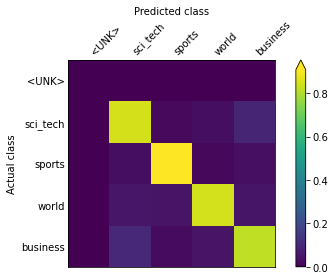

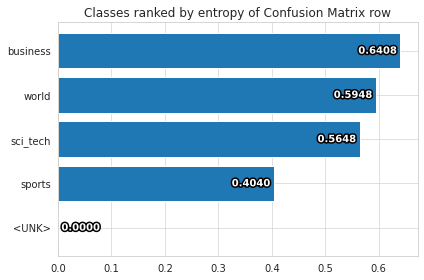

In [7]:
# Visualizes confusion matrix, which gives an overview of classifier performance
# for each class.
from ludwig.visualize import confusion_matrix

confusion_matrix(
  [test_stats],
  model.training_set_metadata,
  'class',
  top_n_classes=[5],
  model_names=[''],
  normalize=True,
)

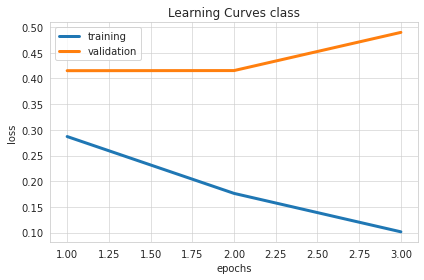

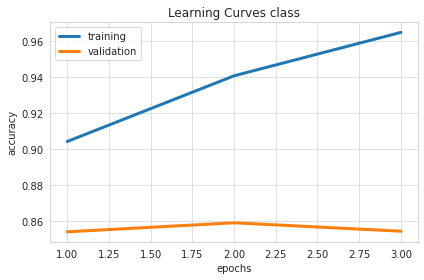

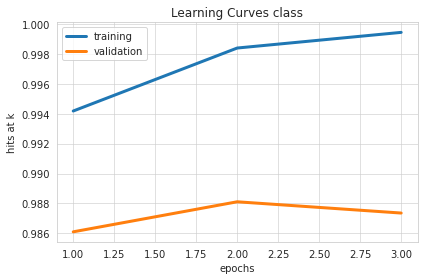

In [8]:
# Visualizes learning curves, which show how performance metrics changed over
# time during training.
from ludwig.visualize import learning_curves

learning_curves(train_stats, output_feature_name='class')

# Make Predictions on New Data

Lastly we'll show how to generate predictions for new data.

The following are some recent news headlines. Feel free to edit or add your own strings to text_to_predict to see how the newly trained model classifies them.

In [9]:
import pandas as pd

text_to_predict = pd.DataFrame({
  "title": [
    "Google may spur cloud cybersecurity M&A with $5.4B Mandiant buy",
    "Europe struggles to meet mounting needs of Ukraine's fleeing millions",
    "How the pandemic housing market spurred buyer's remorse across America",
  ]
})

predictions, output_directory = model.predict(text_to_predict)

predictions

Prediction: 100%|██████████| 1/1 [00:00<00:00, 109.50it/s]


,class_predictions,class_probabilities,class_probability,class_probabilities_<UNK>,class_probabilities_sci_tech,class_probabilities_sports,class_probabilities_world,class_probabilities_business
0,sci_tech,"[3.0832316042506136e-06, 0.6919132471084595, 0...",0.691913,0.000003,0.691913,0.000701,0.005095,0.302288
1,world,"[6.975879841775168e-06, 0.007269156165421009, ...",0.983787,0.000007,0.007269,0.005224,0.983787,0.003713
2,business,"[1.795953357941471e-05, 0.06292799860239029, 0...",0.902341,0.000018,0.062928,0.001052,0.033661,0.902341
